In [2]:
import submitit
import os
import glob
import numpy as np
import pandas as pd
import mne
import submitit
import mne
import numpy as np
from tensorpac import Pac

In [8]:


def compute_and_save_pac(pid):

    
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    
    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    
    # Select specific channels
    epochs = epochs.pick_channels([epochs.ch_names[0]])
    sf = epochs.info['sfreq']
    
    # Load metadata
    meta = epochs.metadata.reset_index()
    
    # Extract data from epochs
    data = epochs.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)

 
    
    # Slice data for the first 500 ms after stimulus onset
    time_500ms = int(0.5 * sf) + int(1 * sf)
    time_0 = int(1 * sf)
    data_with_stimulus_500ms = data1[:,time_0 :time_500ms]
    data_without_stimulus_500ms = data2[:, time_0:time_500ms]
    
    # Initialize the PAC object
    p_obj = Pac(idpac=(6, 0, 0), f_pha=(2, 15, 1, 0.5), f_amp=(20, 100, 4, 1))
    
    # Compute phase and amplitude components for each condition
    pha_with_stimulus = p_obj.filter(sf, data_with_stimulus_500ms, ftype='phase')
    amp_with_stimulus = p_obj.filter(sf, data_with_stimulus_500ms, ftype='amplitude')
    
    pha_without_stimulus = p_obj.filter(sf, data_without_stimulus_500ms, ftype='phase')
    amp_without_stimulus = p_obj.filter(sf, data_without_stimulus_500ms, ftype='amplitude')
    
    # Compute PAC for each condition
    pac_with_stimulus = p_obj.fit(pha_with_stimulus, amp_with_stimulus).mean(-1)
    pac_without_stimulus = p_obj.fit(pha_without_stimulus, amp_without_stimulus).mean(-1)
    
    output_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/pac_results_{condition}.npz'
    # Save the PAC results to the specified output path
    print(f'PAC results saved to {output_path}')
    return  pac_with_stimulus, pac_without_stimulus, p_obj


In [9]:

# Example usage:
pid = '176b4fe3-f570-4d9f-9e25-a5d218f75c8b'
condition = 'Stim_NoStim'

executor = submitit.AutoExecutor(folder="logs")

# pass parameter to the executor
executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=4)

jobs = executor.submit(compute_and_save_pac, pid, condition)  # just a list of jobs



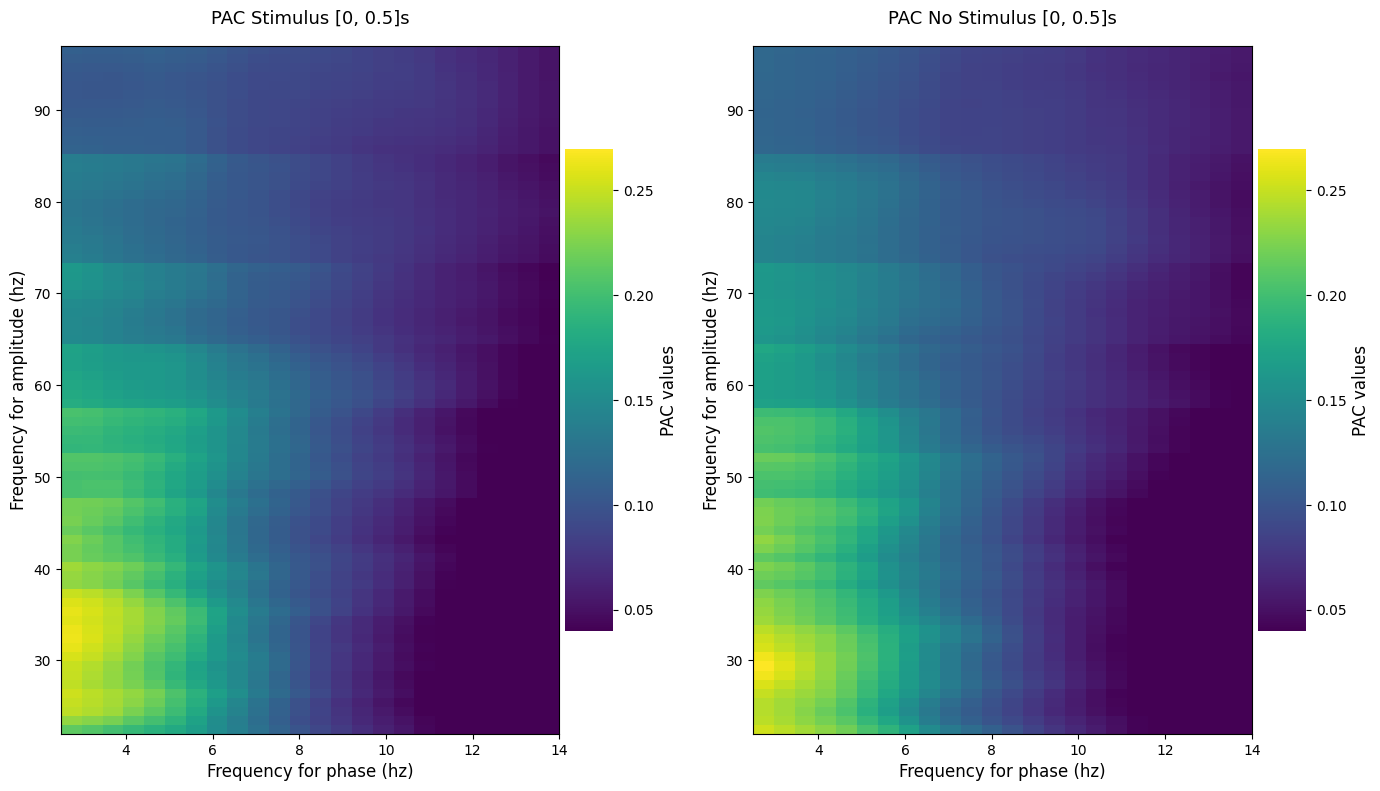

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac

# Assuming pac_with_stimulus, pac_without_stimulus, and p_obj are loaded or calculated previously
pac_with_stimulus, pac_without_stimulus, p_obj = jobs.result()

# Determine the maximum PAC value for consistent color scaling
vmax = np.max([pac_with_stimulus.max(), pac_without_stimulus.max()])
kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

# Create a figure with two subplots
plt.figure(figsize=(14, 8))

# Plot PAC for "With Stimulus" condition
plt.subplot(1, 2, 1)
p_obj.comodulogram(pac_with_stimulus, title="PAC Stimulus [0, 0.5]s", **kw)

# Plot PAC for "Without Stimulus" condition
plt.subplot(1, 2, 2)
p_obj.comodulogram(pac_without_stimulus, title="PAC No Stimulus [0, 0.5]s", **kw)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [5]:
import mne
import numpy as np
from tensorpac import Pac

def compute_and_save_pac(pid, condition):
    """
    Computes and saves PAC (Phase-Amplitude Coupling) for a specified condition and channels.

    Parameters:
    pid (str): Participant ID.
    condition (str): Condition to compare (e.g., 'Stim_NoStim').
    channel_range (tuple): Tuple indicating the range of channels to include (start, end).
    epoch_path_template (str): Path template for the epoch file.
    output_path (str): Path where the PAC results will be saved.
    
    Returns:
    None
    """
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    
    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    
    # Select specific channels
    epochs = epochs.pick_channels([epochs.ch_names[0]])
    sf = epochs.info['sfreq']
    
    # Load metadata
    meta = epochs.metadata.reset_index()
    
    # Extract data from epochs
    data = epochs.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
    # Define condition trials based on the condition parameter
    if condition == 'Stim_NoStim':
        condition1_trial = np.where(((meta['contrastLeft'] == 1) | (meta['contrastRight'] == 1)))[0]
        condition2_trial = np.where(((meta['contrastLeft'] < 0.1) | (meta['contrastRight'] < 0.1)))[0]
    
    # Select data for each condition
    data1 = data[condition1_trial]
    data2 = data[condition2_trial]
    
    # Slice data for the first 500 ms after stimulus onset
    time_500ms_negative = int(0.5 * sf) 
    time_0 = int(1 * sf)
    data_with_stimulus_500ms = data1[...,time_500ms_negative :time_0]
    data_without_stimulus_500ms = data2[..., time_500ms_negative:time_0]
    
    # Initialize the PAC object
    p_obj = Pac(idpac=(6, 0, 0), f_pha=(2, 15, 1, 0.5), f_amp=(20, 100, 4, 1))
    
    # Compute phase and amplitude components for each condition
    pha_with_stimulus = p_obj.filter(sf, data_with_stimulus_500ms, ftype='phase')
    amp_with_stimulus = p_obj.filter(sf, data_with_stimulus_500ms, ftype='amplitude')
    
    pha_without_stimulus = p_obj.filter(sf, data_without_stimulus_500ms, ftype='phase')
    amp_without_stimulus = p_obj.filter(sf, data_without_stimulus_500ms, ftype='amplitude')
    
    # Compute PAC for each condition
    pac_with_stimulus = p_obj.fit(pha_with_stimulus, amp_with_stimulus).mean(-1)
    pac_without_stimulus = p_obj.fit(pha_without_stimulus, amp_without_stimulus).mean(-1)
    
    output_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/pac_results_{condition}.npz'
    # Save the PAC results to the specified output path
    print(f'PAC results saved to {output_path}')
    return  pac_with_stimulus, pac_without_stimulus, p_obj


In [6]:

# Example usage:
pid = '176b4fe3-f570-4d9f-9e25-a5d218f75c8b'
condition = 'Stim_NoStim'

executor = submitit.AutoExecutor(folder="logs")

# pass parameter to the executor
executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=4)

jobs = executor.submit(compute_and_save_pac, pid, condition)  # just a list of jobs



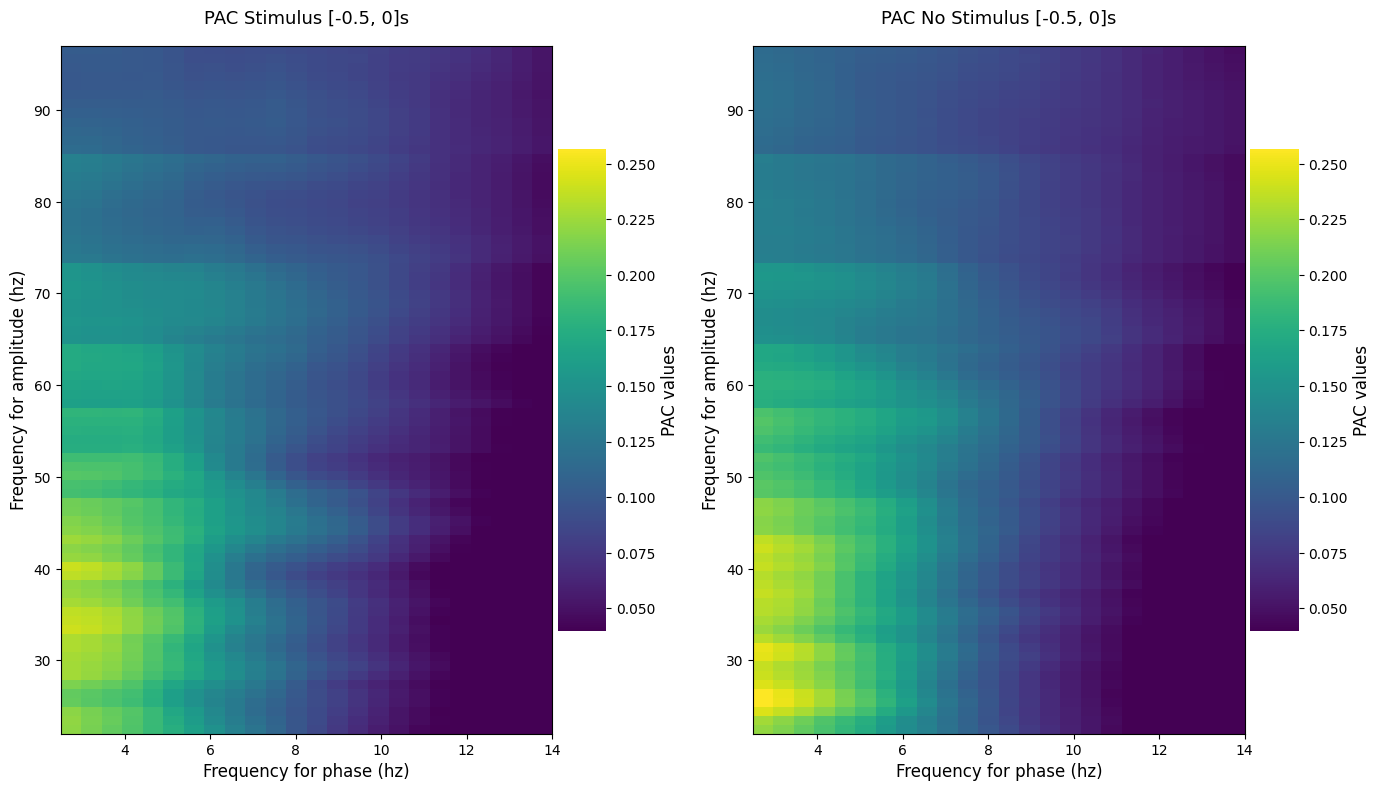

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac

# Assuming pac_with_stimulus, pac_without_stimulus, and p_obj are loaded or calculated previously
pac_with_stimulus, pac_without_stimulus, p_obj = jobs.result()

# Determine the maximum PAC value for consistent color scaling
vmax = np.max([pac_with_stimulus.max(), pac_without_stimulus.max()])
kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

# Create a figure with two subplots
plt.figure(figsize=(14, 8))

# Plot PAC for "With Stimulus" condition
plt.subplot(1, 2, 1)
p_obj.comodulogram(pac_with_stimulus, title="PAC Stimulus [-0.5, 0]s", **kw)

# Plot PAC for "Without Stimulus" condition
plt.subplot(1, 2, 2)
p_obj.comodulogram(pac_without_stimulus, title="PAC No Stimulus [-0.5, 0]s", **kw)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [19]:
import mne
import numpy as np
from tensorpac import Pac

def compute_and_save_pac(pid):

    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    
    dir = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures/{pid}'
    os.makedirs(dir, exist_ok=True)
    # Load metadata
    
    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    sf = epochs.info['sfreq']
    meta = epochs.metadata.reset_index()
    for ch in epochs.ch_names:
    # Select specific channels
    
        epoch = epochs.copy().pick_channels([ch])
 
        
        # Extract data from epochs
        data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
        # Define condition trials based on the condition parameter
        stim_indices = np.where(((meta['contrastLeft'] > 0.1) | (meta['contrastRight'] > 0.1)))[0]
        
        # Select data for each condition
        data1 = data[stim_indices]
        data2 = data[stim_indices]
        # Slice data for the first 500 ms after stimulus onset
        time_500ms_negative = int(0.5 * sf) # -500
        time_0 = int(1 * sf) # 0
        time_1000ms_pos = int(2 * sf) # 1s 

        data_beforestim = data1[...,time_500ms_negative :time_0]
        data_afterstim = data2[..., time_0:time_1000ms_pos]
        
        # Initialize the PAC object
        p_obj = Pac(idpac=(6, 0, 0), f_pha=(2, 15, 1, 0.5), f_amp=(25, 100, 4, 1))
        
        # Compute phase and amplitude components for each condition
        pha_afterstim = p_obj.filter(sf, data_afterstim, ftype='phase')
        amp_afterstim = p_obj.filter(sf, data_afterstim, ftype='amplitude')
        
        pha_beforestim = p_obj.filter(sf, data_beforestim, ftype='phase')
        amp_beforestim = p_obj.filter(sf, data_beforestim, ftype='amplitude')
        
        # Compute PAC for each condition
        pac_afterstim = p_obj.fit(pha_afterstim, amp_afterstim).mean(-1)
        pac_beforestim = p_obj.fit(pha_beforestim, amp_beforestim).mean(-1)
        
        
        vmax = np.max([pac_afterstim.max(), pac_beforestim.max()])
        kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

        # Create a figure with two subplots
        plt.figure(figsize=(14, 8))

        # Plot PAC for "With Stimulus" condition
        plt.subplot(1, 2, 1)
        p_obj.comodulogram(pac_beforestim, title= f" {ch} before stim [-0.5, 0]s", **kw)

        # Plot PAC for "Without Stimulus" condition
        plt.subplot(1, 2, 2)
        p_obj.comodulogram(pac_afterstim, title="after stim  [0, 1]s", **kw)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.savefig(f'{dir}/beforeVSafterstim_{ch}.png')
    
 
    return 

path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values


for i, pid in enumerate(pids): 


    executor = submitit.AutoExecutor(folder="logs")

    # pass parameter to the executor
    executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=4)

    jobs = executor.submit(compute_and_save_pac, pid)  # just a list of jobs



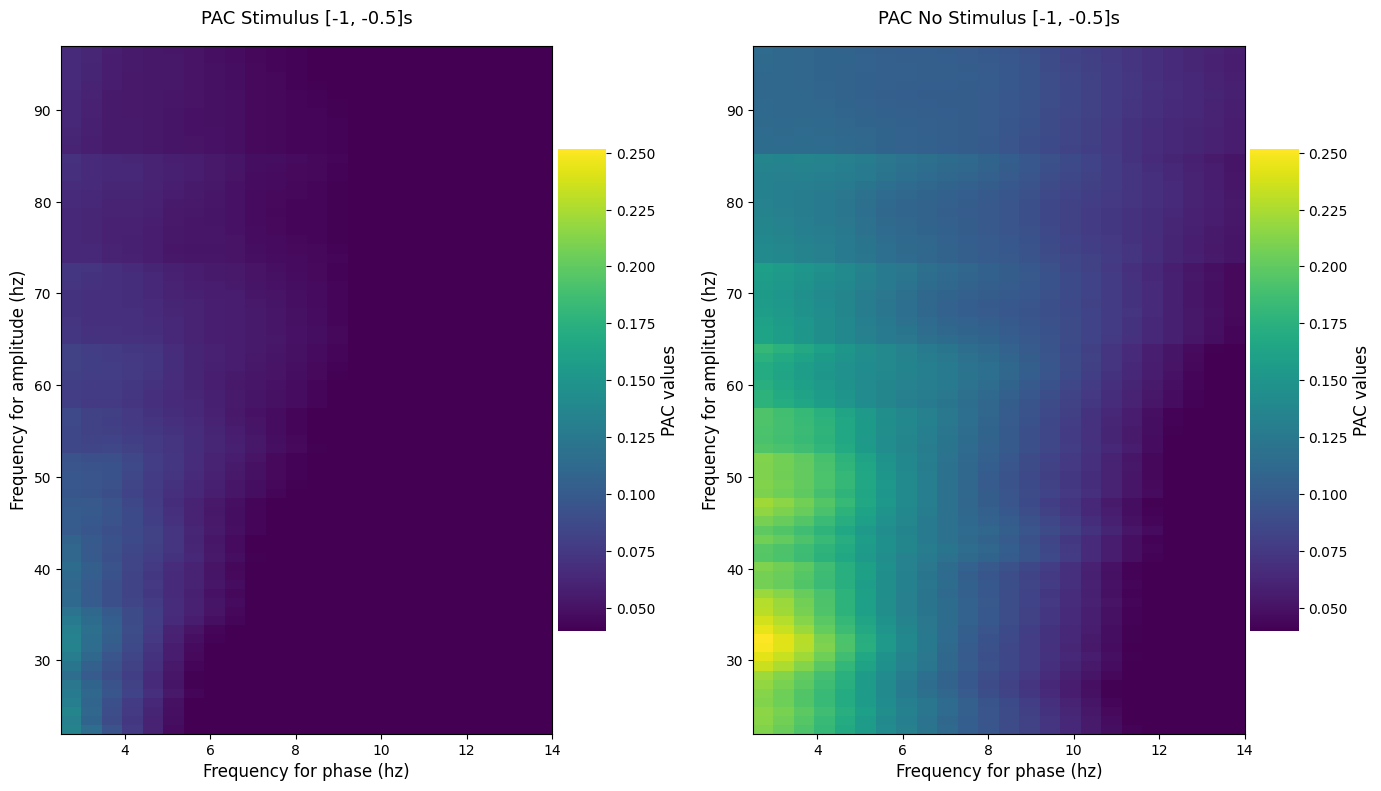

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorpac import Pac

# Assuming pac_with_stimulus, pac_without_stimulus, and p_obj are loaded or calculated previously
pac_with_stimulus, pac_without_stimulus, p_obj = jobs.result()

# Determine the maximum PAC value for consistent color scaling
vmax = np.max([pac_with_stimulus.max(), pac_without_stimulus.max()])
kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

# Create a figure with two subplots
plt.figure(figsize=(14, 8))

# Plot PAC for "With Stimulus" condition
plt.subplot(1, 2, 1)
p_obj.comodulogram(pac_with_stimulus, title="before stim [-0.5, 0]s", **kw)

# Plot PAC for "Without Stimulus" condition
plt.subplot(1, 2, 2)
p_obj.comodulogram(pac_without_stimulus, title="after stim  [0, 1]s", **kw)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/pac_results_{condition}.png')

In [18]:
pid = 'd213e786-4b1c-477d-a710-766d69fa1ac1'


epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'



# Load metadata

# Load the epochs
epochs = mne.read_epochs(epoch_path, preload=True)
sf = epochs.info['sfreq']
meta = epochs.metadata.reset_index()
for i, ch in enumerate(epochs.ch_names):
    
    if i >0:
        break 
# Select specific channels

    epoch = epochs.copy().pick_channels([ch])

    
    # Extract data from epochs
    data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
    # Define condition trials based on the condition parameter
    stim_indices = np.where(((meta['contrastLeft'] > 0.1) | (meta['contrastRight'] > 0.1)))[0]
    
    # Select data for each condition
    data = data[stim_indices]
    
    # Slice data for the first 500 ms after stimulus onset
    time_500ms_negative = int(0.5 * sf) # -500
    time_0 = int(1 * sf) # 0
    time_1000ms_pos = int(2 * sf) # 1s 

    data_beforestim = data[...,time_500ms_negative :time_0]
    data_afterstim = data[..., time_0:time_1000ms_pos]
    
    # Initialize the PAC object
    p_obj = Pac(idpac=(6, 0, 0), f_pha=(2, 15, 1, 0.5), f_amp=(25, 100, 4, 1))
    
    # Compute phase and amplitude components for each condition
    pha_afterstim = p_obj.filter(sf, data_afterstim, ftype='phase')
    amp_afterstim = p_obj.filter(sf, data_afterstim, ftype='amplitude')
    
    pha_beforestim = p_obj.filter(sf, data_beforestim, ftype='phase')
    amp_beforestim = p_obj.filter(sf, data_beforestim, ftype='amplitude')
    
    # Compute PAC for each condition
    pac_afterstim = p_obj.fit(pha_afterstim, amp_afterstim).mean(-1)
    pac_beforestim = p_obj.fit(pha_beforestim, amp_beforestim).mean(-1)
    
    
    vmax = np.max([pac_afterstim.max(), pac_beforestim.max()])
    kw = dict(vmax=vmax, vmin=.04, cmap='viridis')

    # Create a figure with two subplots
    plt.figure(figsize=(14, 8))

    # Plot PAC for "With Stimulus" condition
    plt.subplot(1, 2, 1)
    p_obj.comodulogram(pac_beforestim, title= f" {ch} before stim [-0.5, 0]s", **kw)

    # Plot PAC for "Without Stimulus" condition
    plt.subplot(1, 2, 2)
    p_obj.comodulogram(pac_afterstim, title="after stim  [0, 1]s", **kw)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show


Reading /mnt/data/AdaptiveControl/IBLrawdata/pid_data/d213e786-4b1c-477d-a710-766d69fa1ac1/lfp_d213e786-4b1c-477d-a710-766d69fa1ac1_epoched.fif ...
Isotrak not found


/tmp/ipykernel_99640/3183887420.py:11: RuntimeWarning: This filename (/mnt/data/AdaptiveControl/IBLrawdata/pid_data/d213e786-4b1c-477d-a710-766d69fa1ac1/lfp_d213e786-4b1c-477d-a710-766d69fa1ac1_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epoch_path, preload=True)


    Found the data of interest:
        t =   -1000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 16 columns
577 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/tmp/ipykernel_99640/3183887420.py:24: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
Phase Amplitude Coupling object defined
    true PAC estimation using Gaussian Copula PAC (gcPac)
    true PAC estimation using Gaussian Copula PAC (gcPac)


In [ ]:
plt.figure(figsize=(8, 6))
rp_obj.pacplot(pac_with_stimulus.squeeze(), times, rp_obj.yvec, xlabel='Time',
                ylabel='Amplitude frequency (Hz)',
                title=f'Event-Related PAC for {layer} (Phase = [2, 7])', 
                fz_labels=15, fz_title=18)
plt.show()

In [ ]:
import mne
import numpy as np
from tensorpac import Pac

def compute_and_save_pac(pid, condition):
    """
    Computes and saves PAC (Phase-Amplitude Coupling) for a specified condition and channels.

    Parameters:
    pid (str): Participant ID.
    condition (str): Condition to compare (e.g., 'Stim_NoStim').
    channel_range (tuple): Tuple indicating the range of channels to include (start, end).
    epoch_path_template (str): Path template for the epoch file.
    output_path (str): Path where the PAC results will be saved.
    
    Returns:
    None
    """
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    
    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    
    # Select specific channels
    epochs = epochs.pick_channels([epochs.ch_names[0]])
    sf = epochs.info['sfreq']
    
    # Load metadata
    meta = epochs.metadata.reset_index()
    
    # Extract data from epochs
    data = epochs.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)

    
    # Slice data for the first 500 ms after stimulus onset
    time_500ms_negative = int(0.5 * sf) 
    time_0 = int(1 * sf)
    time_500ms_positive = int(1.5 * sf)
    time_1000ms = int(1.9 * sf)
    data0 = data[...,0 :time_500ms_negative]
    data1 = data[..., time_500ms_negative:time_0]
    data2 =data[..., time_0:time_500ms_positive]
    data3 = data[..., time_500ms_positive:time_1000ms]
  
    # Initialize the PAC object
    p_obj = Pac(idpac=(6, 0, 0), f_pha=(2, 15, 1, 0.5), f_amp=(20, 100, 4, 1))
    X = [data0, data1, data2, data3]
    for x in X:
        # Compute phase and amplitude components for each condition
        pha = p_obj.filter(sf, x, ftype='phase')
        amp = p_obj.filter(sf, x, ftype='amplitude')
        # Compute PAC for each condition
        pac = p_obj.fit(pha, amp).mean(-1)
      


# Example usage:
pid = '176b4fe3-f570-4d9f-9e25-a5d218f75c8b'
condition = 'Stim_NoStim'

executor = submitit.AutoExecutor(folder="logs")

# pass parameter to the executor
executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=4)

jobs = executor.submit(compute_and_save_pac, pid, condition)  # just a list of jobs



In [3]:
import mne
import numpy as np
from tensorpac import Pac
import matplotlib.pyplot as plt

def compute_and_plot_pac(pid):
    """
    Computes and plots PAC (Phase-Amplitude Coupling) for four time segments.

    Parameters:
    pid (str): Participant ID.
    condition (str): Condition to compare (e.g., 'Stim_NoStim').
    
    Returns:
    None
    """
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    epochs = epochs[epochs.metadata['skewness'] < 1.5]
    # Select specific channels
    channels= epochs.ch_names
    dir= f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures/{pid}'
    os.makedirs(dir, exist_ok=True)
    for i, ch in enumerate(channels):
        
        if i > 0:
            break
        
        epoch = epochs.copy().pick_channels([ch])
        sf = epochs.info['sfreq']
        
        # Load metadata
        meta = epoch.metadata.reset_index()
        
        stim_indices = np.where(((meta['contrastLeft'] > 0) | (meta['contrastRight'] > 0)))[0]

        # Extract data from epoch
        data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_channels, n_times)
        data = data[stim_indices, :]
        # Slice data into four segments
        time_500ms_negative = int(0.5 * sf) 
        time_0 = int(1 * sf)
        time_500ms_positive = int(1.5 * sf)
        time_1000ms = int(2 * sf)
        time_1500ms = int(2.5 * sf)
        time_2000ms = int(2.9 * sf)
        data0 = data[..., 0:time_500ms_negative]
        data1 = data[..., time_500ms_negative:time_0]
        data2 = data[..., time_0:time_500ms_positive]
        data3 = data[..., time_500ms_positive:time_1000ms]
        data4 = data[..., time_1000ms:time_1500ms]
        data5 = data[..., time_1500ms:time_2000ms]
    
        # Initialize the PAC object
        p_obj = Pac(idpac=(6, 0, 0), f_pha=(2, 8, 1, 0.5), f_amp=(20, 40, 1, 1))
        X = [data0, data1, data2, data3, data4, data5]
        pac_results = []

        for x in X:
            # Compute phase and amplitude components for each time segment
            pha = p_obj.filter(sf, x, ftype='phase')
            amp = p_obj.filter(sf, x, ftype='amplitude')
            # Compute PAC for each segment
            pac = p_obj.fit(pha, amp).mean(-1)
            pac_results.append(pac)

        # Plot PAC for all four segments
        plt.figure(figsize=(20, 10))

        segment_titles = ["PAC Segment 1 [-1.0, -0.5]s", "PAC Segment 2 [-0.5, 0.0]s", 
                        "PAC Segment 3 [0.0, 0.5]s", "PAC Segment 4 [0.5, 1.0]s", "PAC Segment 5 [1.0, 1.5]s", "PAC Segment 6 [1.5, 1.9]s"]
        
        vmax = np.max([pac.max() for pac in pac_results])
        kw = dict(vmax=vmax, vmin=.04, cmap='viridis')
        
        for i, pac in enumerate(pac_results):
            plt.subplot(2, 3, i+1)
            p_obj.comodulogram(pac, title=segment_titles[i], **kw)
            
        plt.suptitle(f'Phase-Amplitude Coupling (PAC) for Channel: {ch}', fontsize=16)

        plt.tight_layout()    

        # plt.savefig(f'{dir}/new_pac_{ch}.png')
        # plt.close()
        plt.show()

In [9]:
compute_and_plot_pac(pid = '176b4fe3-f570-4d9f-9e25-a5d218f75c8b')

NameError: name 'compute_and_plot_pac' is not defined

In [16]:
import os
import urllib
import pandas as pd
import numpy as np
from scipy.io import loadmat

from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude

import matplotlib.pyplot as plt

In [17]:
import mne
import numpy as np
from tensorpac import Pac
import matplotlib.pyplot as plt
import submitit 
pid = '176b4fe3-f570-4d9f-9e25-a5d218f75c8b'

def paccompute(pid):
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    epochs = epochs[epochs.metadata['skewness'] < 1.5]
    # Select specific channels
    channels= epochs.ch_names
    dir= f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures/{pid}'
    os.makedirs(dir, exist_ok=True)

    times = epochs.times
    for i, ch in enumerate(channels):
        
        if i > 0:
            break
        
        epoch = epochs.copy().pick_channels([ch])
        sf = epochs.info['sfreq']
        
        # Load metadata
        meta = epoch.metadata.reset_index()
        
        stim_indices = np.where(((meta['contrastLeft'] > 0) | (meta['contrastRight'] > 0)))[0]
        reward_indices = np.where(meta['feedbackType'] == 1)[0]
        indices = np.intersect1d(stim_indices, reward_indices)
        # Extract data from epoch
        data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_times)
        data = data[indices, :]
    
        rp_obj = EventRelatedPac(f_pha=[2, 8], f_amp=(20, 45, 1, 1))
        erpac = rp_obj.filterfit(sf, data, method='gc', smooth=100)

        plt.figure(figsize=(8, 6))
        rp_obj.pacplot(erpac.squeeze(), times, rp_obj.yvec, xlabel='Time',
                    ylabel='Amplitude frequency (Hz)',
                    title='Event-Related PAC occurring for f phase = [2, 7]', 
                    fz_labels=15, fz_title=18)
        plt.savefig(f'{dir}/feedback_{ch}.png')
                
    return 

path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values


for i, pid in enumerate(pids): 
    
    if i> 0:
        break   
    print(pid)       
    executor = submitit.AutoExecutor(folder="logs")
    # pass parameter to the executor
    executor.update_parameters(mem_gb=10, timeout_min=600, slurm_partition="CPU", cpus_per_task=4)
    # execute the job (note the .map_array command that different from the .submit command used above)
    jobs = executor.submit(paccompute, pid)







3d3d5a5e-df26-43ee-80b6-2d72d85668a5


In [21]:
def paccompute(pid):
    epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'

    # Load the epochs
    epochs = mne.read_epochs(epoch_path, preload=True)
    
    epochs = epochs.crop(-0.5, 1)
    meta = epochs.metadata.reset_index()
            
    # Select indices where both conditions are met
    stim_indices = np.where(((meta['contrastLeft'] > 0) | (meta['contrastRight'] > 0)))[0]
    reward_indices = np.where(meta['feedbackType'] == 1)[0]
    clean = np.where(meta['skewness'] < 1.5)[0]
    indices = np.intersect1d(stim_indices, reward_indices)
    indices = np.intersect1d(indices, clean)
    

    # Get all channel names
    channels = epochs.ch_names
    
    # Define the layers and dynamically select channels for each layer
    layers = {
        'VISp1': [ch for ch in channels if 'VISp1' in ch],
        'VISp2': [ch for ch in channels if 'VISp2' in ch],
        'VISp4': [ch for ch in channels if 'VISp4' in ch],
        'VISp5': [ch for ch in channels if 'VISp5' in ch],
        'VISp6': [ch for ch in channels if 'VISp6' in ch]
    }

    dir = f'/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures/{pid}'
    os.makedirs(dir, exist_ok=True)
    
    sf = epochs.info['sfreq']

    for layer, layer_channels in layers.items():
        if len(layer_channels) == 0:
            continue  # Skip layers without any channels
        
        layer_erpac_list = []  # List to store PAC results for all channels in the layer

        for ch in layer_channels:
            # Pick the current channel
            epoch = epochs.copy().pick_channels([ch])
            
            # Load metadata
            
            # Extract data from epoch using the selected indices
            data = epoch.get_data().squeeze()  # Shape: (n_epochs, n_times)
            data = data[indices, :]  # Filter by the selected indices
            
            # Initialize PAC object and calculate event-related PAC
            rp_obj = EventRelatedPac(f_pha=[2, 7], f_amp=(20, 45, 1, 1))
            erpac = rp_obj.filterfit(sf, data, method='gc', smooth=100)
            
            layer_erpac_list.append(erpac)
        
        # Average the PAC results across all channels in the layer
        averaged_erpac = np.mean(layer_erpac_list, axis=0)  # Average across the list (channels)
        
        # Save the averaged PAC result for the current layer
        np.save(f'{dir}/erpac_{layer}_{pid}.npy', averaged_erpac)
        

        plt.figure(figsize=(8, 6))
        rp_obj.pacplot(averaged_erpac.squeeze(), epochs.times, rp_obj.yvec, xlabel='Time',
                    ylabel='Amplitude frequency (Hz)',
                    title='Event-Related PAC occurring for phase = [2, 7]', 
                    fz_labels=15, fz_title=18)
        plt.savefig(f'{dir}/{layer}_average.png')
        
        
path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values


for i, pid in enumerate(pids): 
    
     
    print(pid)       
    executor = submitit.AutoExecutor(folder="logs")
    # pass parameter to the executor
    executor.update_parameters(mem_gb=20, timeout_min=600, slurm_partition="CPU", cpus_per_task=5)
    # execute the job (note the .map_array command that different from the .submit command used above)
    jobs = executor.submit(paccompute, pid)





3d3d5a5e-df26-43ee-80b6-2d72d85668a5
4b93a168-0f3b-4124-88fa-a57046ca70e1
a9c9df46-85f3-46ad-848d-c6b8da4ae67c
b72b22c2-6e9d-4604-9910-20c0e1a467d7
18d316bf-d322-4c5c-814e-a58147f7bf5f
c4f6665f-8be5-476b-a6e8-d81eeae9279d
d213e786-4b1c-477d-a710-766d69fa1ac1
b78b3c42-eee5-47c6-9717-743b78c0b721
b114e7e0-92b3-43bb-9529-53860e52606d
578ca001-8cf5-4d30-b58f-1d574eaf808a
fb0de39b-c750-4adc-af18-12bf8a22ed41
b40d8c65-7ee8-4069-8b64-1a3f7907742f
f9d8aacd-b2a0-49f2-bd71-c2f5aadcfdd1
b76f24ea-95b1-4a0e-95eb-9c39b1283c40
7cbecb3f-6a8a-48e5-a3be-8f7a762b5a04
e5bc1f00-f4b8-4b35-a9b6-60d9cc7959a1
febb430e-2d50-4f83-87a0-b5ffbb9a4943
2400a2fa-0335-480b-ac8d-a478171f3a55
88fe9ed9-9e3e-431a-8ecc-4cb2fe5bf448
1f555fc6-5067-428b-a284-da6fb0b6b3a0
e4ce2e94-6fb9-4afe-acbf-6f5a3498602e
27bac116-ea57-4512-ad35-714a62d259cd
85bdeae3-269b-4e39-bd9b-2b0d95aff2fa
c6ba6f8e-c13e-410f-b7df-e193ba0d239d
22609d51-0a6a-425d-a3ef-eeb43a9ba350
df07180e-268e-489c-826e-40cb6f63d3a5
176b4fe3-f570-4d9f-9e25-a5d218f75c8b
c

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt

def load_and_average_pac(pids, layers, base_dir):
    # Dictionary to store PAC data for each layer
    layer_pac_data = {layer: [] for layer in layers}

    # Load PAC data for each PID and accumulate it by layer
    for pid in pids:
        for layer in layers:
            pac_path = os.path.join(base_dir, pid,  f'erpac_{layer}_{pid}.npy')
            if os.path.exists(pac_path):
                pac_data = np.load(pac_path)
                layer_pac_data[layer].append(pac_data)
    
    # Average PAC data across PIDs for each layer
    averaged_layer_pac = {layer: np.mean(layer_pac_data[layer], axis=0) for layer in layers if layer_pac_data[layer]}
    
    return averaged_layer_pac



# Define the layers you have processed
layers = ['VISp1', 'VISp2', 'VISp4', 'VISp5', 'VISp6']
path = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/preprocessing/clean_data.csv'
df = pd.read_csv(path)
pids = df['pid'].values
# Base directory where PAC data is stored
base_dir = '/crnldata/cophy/TeamProjects/mohammad/ibl-oscillations/_analyses/_IBLworkflows/PAC/figures'

# Load and average PAC data
averaged_layer_pac = load_and_average_pac(pids, layers, base_dir)




Reading /mnt/data/AdaptiveControl/IBLrawdata/pid_data/27bac116-ea57-4512-ad35-714a62d259cd/lfp_27bac116-ea57-4512-ad35-714a62d259cd_epoched.fif ...
Isotrak not found
    Found the data of interest:
        t =   -1000.00 ...    1999.99 ms
        0 CTF compensation matrices available


/tmp/ipykernel_99640/911673911.py:16: RuntimeWarning: This filename (/mnt/data/AdaptiveControl/IBLrawdata/pid_data/27bac116-ea57-4512-ad35-714a62d259cd/lfp_27bac116-ea57-4512-ad35-714a62d259cd_epoched.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epoch_path, preload=True)


Adding metadata with 16 columns
724 matching events found
No baseline correction applied
0 projection items activated


Event Related PAC object defined


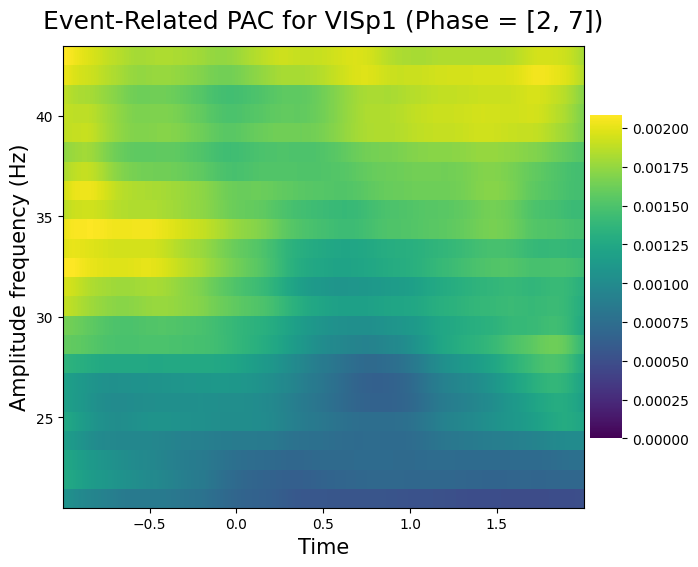

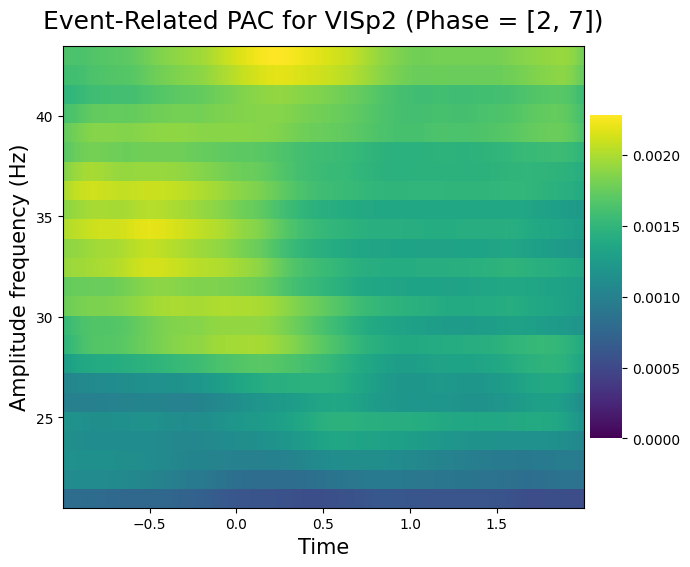

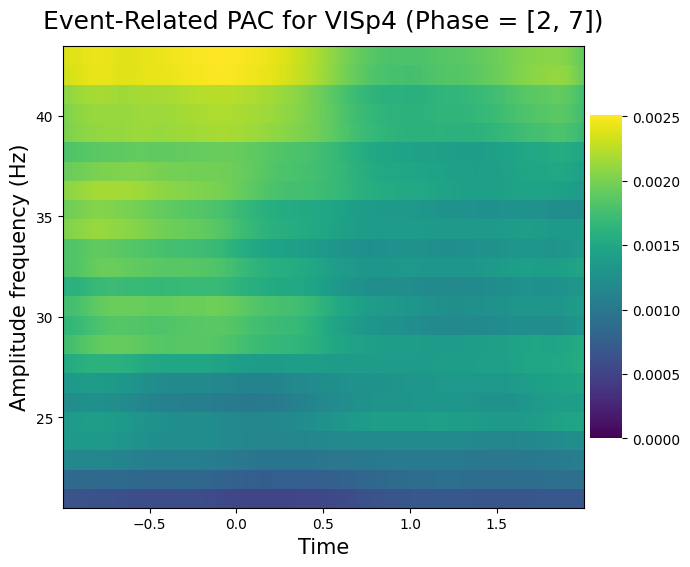

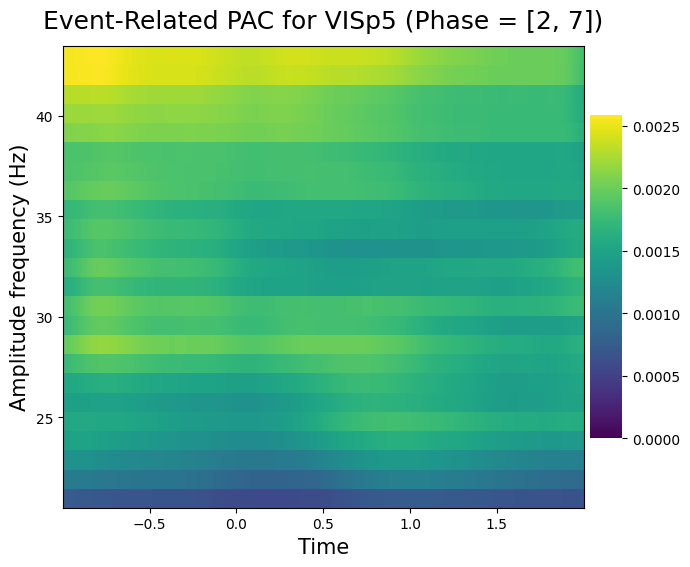

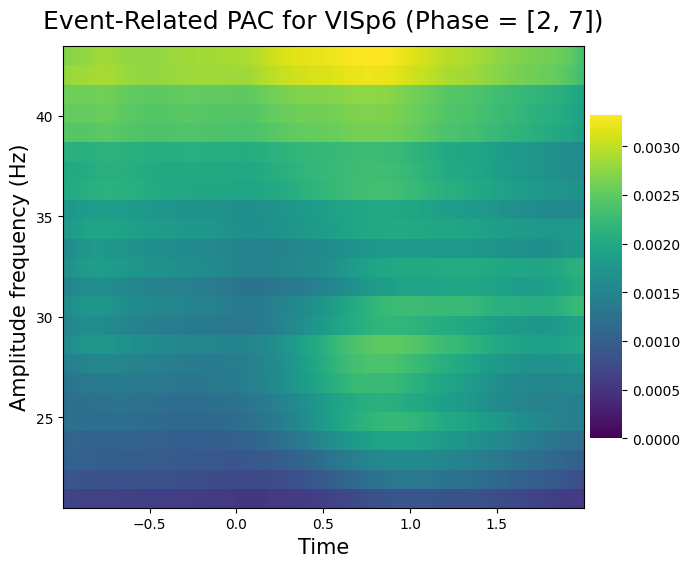

In [8]:

import os
import urllib
import pandas as pd
import numpy as np
from scipy.io import loadmat

from tensorpac import Pac, EventRelatedPac, PreferredPhase
from tensorpac.utils import PeakLockedTF, PSD, ITC, BinAmplitude

import matplotlib.pyplot as plt
pid = '27bac116-ea57-4512-ad35-714a62d259cd'
epoch_path = f'/mnt/data/AdaptiveControl/IBLrawdata/pid_data/{pid}/lfp_{pid}_epoched.fif'
layers = ['VISp1', 'VISp2', 'VISp4', 'VISp5', 'VISp6']

# Load the epochs
epochs = mne.read_epochs(epoch_path, preload=True)
times = epochs.times
epochs = epochs.crop(-0.5, 1)

# Initialize EventRelatedPac object
rp_obj = EventRelatedPac(f_pha=[2, 7], f_amp=(20, 45, 1, 1))

# Assuming `averaged_layer_pac` is already computed and available
for layer in layers:
    data = averaged_layer_pac[layer]  # Get the PAC data for the current layer
    
    plt.figure(figsize=(8, 6))
    rp_obj.pacplot(data.squeeze(), times, rp_obj.yvec, xlabel='Time',
                   ylabel='Amplitude frequency (Hz)',
                   title=f'Event-Related PAC for {layer} (Phase = [2, 7])', 
                   fz_labels=15, fz_title=18)
    plt.show()
